## Initial setup

Validate your python environment here.

In [1]:
import gzip
import os
import urllib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rdkit
import rdkit.Chem
import rdkit.Chem.Draw


Specify some configurations for the notebook.

In [2]:
DOWNLOAD_DIR = "datasets"

SOURCES = {
    "clintox": {
        "download_url": "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clintox.csv.gz",
        "file_name": "clintox.csv",
    },
    "toxcast": {
        "download_url": "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/toxcast_data.csv.gz",
        "file_name": "toxcast.csv",
    },
    "pcba": {
        "download_url": "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/pcba.csv.gz",
        "file_name": "pcba.csv",
    },
}

Now we'll define some data loading helpers:
- `fetch_data` downloads a local copy of the files specified in `SOURCES` above.
- `load_data(name)` returns a dataframe that was extracted from the downloaded file.

Example usages can be seen below.

In [3]:
# We'll maintain a global cache of dataframes to avoid re-loading them
global DATA_CACHE
DATA_CACHE = {}


def fetch_data(source, force_redownload=False):
    # create storage path if it does not exist
    storage_path = os.path.join(DOWNLOAD_DIR, source)
    if not os.path.isdir(storage_path):
        os.makedirs(storage_path)

    # download file if it does not exist or if we want a fresh copy
    gz_file_path = os.path.join(storage_path, f"{SOURCES[source]['file_name']}.gz") 
    if not os.path.isfile(gz_file_path) or force_redownload:
        urllib.request.urlretrieve(SOURCES[source]["download_url"], gz_file_path)


def load_data(name):
    file_path = os.path.join(DOWNLOAD_DIR, name, SOURCES[name]["file_name"])

    #check if we've already loaded this data
    global DATA_CACHE
    if name in DATA_CACHE:
        return DATA_CACHE[name]

    # extract csv if we haven't already
    gz_file_path = f"{file_path}.gz"
    if not os.path.isfile(file_path):
        with gzip.open(gz_file_path, "rb") as f_in:
            with open(file_path, "wb") as f_out:
                f_out.write(f_in.read())

    data = pd.read_csv(file_path)

    # apply any initial cleaning through queries
    if name == "clintox":
        # # query for rows
        # data = data.query('''
        #     NOTE query goes here
        # ''').reset_index()
        pass
    elif name == "toxcast":
        # # query for rows
        # data = data.query('''
        #     NOTE query goes here
        # ''').reset_index()
        pass

    DATA_CACHE[name] = data
    return data


In [4]:
for source in SOURCES:
    fetch_data(source, force_redownload=False)

## Exploration

Starting with some basic inspection

It could help to get a better understanding of the SMILES format by comparing it to the actual molecule. Running this cell will give you a comparison for a random molecule in the toxcast dataset.

C[NH+]1CCC(=C2c3ccccc3C=Cc4c2cccc4)CC1


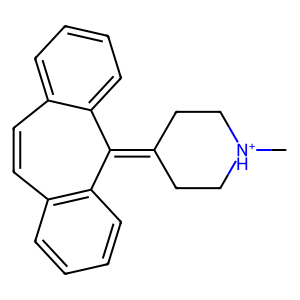

In [5]:
def random_molecule():
    clintox_data = load_data("clintox")
    return clintox_data["smiles"][np.random.randint(len(clintox_data))]

def display_molecule(molecule):
    print(molecule)
    return rdkit.Chem.Draw.MolToImage(rdkit.Chem.MolFromSmiles(molecule))

display_molecule(random_molecule())

# Data Exploration 

In [8]:
## Load Data ##
df_c = load_data("clintox")
df_t = load_data("toxcast")
df_p = load_data("pcba")

In [9]:
from preprocessing.preprocessing import compute_full_preprocessing
import time

## Compute Full Preprocessing: Generate Chemistry Features and Target Column ##
"""
Target Column = 1 if any Assay Feature was positive (1)
Target Column = 0 if all Assay Features were negative (0) or Null
"""

time0 = time.time()
df_p = compute_full_preprocessing(df_p, subset_size = 0.4, dataset = "pcba")
time1 = time.time()

print(f"Time: {time1-time0}s")
df_p

[18:53:40] WARNING: not removing hydrogen atom without neighbors


<class 'pandas.core.frame.DataFrame'>


C:\Users\rockh\anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: divide by zero encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\rockh\anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


Original DataFrame Size: 175172
Processed DataFrame Size: 175105
Processed / Original Size Ratio: 100.0%
Time: 312.4757812023163s


,molecule,toxicity_target,radical_electrons,total_molecular_weight,avg_molecule_weight_no_hydrogens,valence_electrons,avg_molecule_weight,max_partial_charge,min_partial_charge,aliphatic_carbocycles,...,fingerprint_246,fingerprint_247,fingerprint_248,fingerprint_249,fingerprint_250,fingerprint_251,fingerprint_252,fingerprint_253,fingerprint_254,fingerprint_255
0,<rdkit.Chem.rdchem.Mol object at 0x00000204E29...,1,0,442.240247,408.357,168,442.629,0.317115,-0.496768,1,...,0,0,0,0,0,1,0,1,0,0
1,<rdkit.Chem.rdchem.Mol object at 0x00000204E2C...,1,0,350.097917,338.232,128,350.328,0.278556,-0.284926,0,...,0,0,1,0,0,0,0,0,0,1
2,<rdkit.Chem.rdchem.Mol object at 0x00000204E2C...,1,0,214.110613,200.156,82,214.268,0.217960,-0.475454,0,...,0,0,0,0,0,0,0,0,0,0
3,<rdkit.Chem.rdchem.Mol object at 0x00000204E2C...,1,0,414.082032,396.368,144,414.512,0.263724,-0.361543,0,...,1,0,1,0,0,0,0,0,0,1
4,<rdkit.Chem.rdchem.Mol object at 0x00000204E2C...,0,0,296.119463,276.232,110,296.392,0.349807,-0.461753,1,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175100,<rdkit.Chem.rdchem.Mol object at 0x00000204B04...,0,0,219.100777,206.140,84,219.244,0.136880,-0.393615,0,...,0,0,0,0,0,0,0,0,0,0
175101,<rdkit.Chem.rdchem.Mol object at 0x00000204B04...,0,0,324.093249,308.277,116,324.405,0.246563,-0.310264,0,...,0,0,0,0,0,0,0,0,0,0
175102,<rdkit.Chem.rdchem.Mol object at 0x00000204B04...,0,0,283.064471,273.178,104,283.258,0.261475,-0.292146,0,...,0,0,0,0,0,0,0,0,0,0
175103,<rdkit.Chem.rdchem.Mol object at 0x00000204B04...,1,0,305.056719,293.625,108,305.721,0.287759,-0.483713,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
from preprocessing.preprocessing import *

## Compute Full Preprocessing: Generate Chemistry Features and Target Column ##
"""
Target Column = 1 if any Assay Feature was positive (1)
Target Column = 0 if all Assay Features were negative (0) or Null
"""
# Ignore SMILES Parse Errors

df_t = compute_full_preprocessing(df_t)
df_t

[18:14:03] Explicit valence for atom # 0 F, 2, is greater than permitted
[18:14:03] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[18:14:03] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[18:14:03] WARNING: not removing hydrogen atom without neighbors
[18:14:03] Explicit valence for atom # 3 Si, 8, is greater than permitted
[18:14:03] Explicit valence for atom # 3 Si, 8, is greater than permitted
[18:14:03] SMILES Parse Error: syntax error while parsing: FAIL
[18:14:03] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input: 'FAIL'
[18:14:04] SMILES Parse Error: syntax error while parsing: FAIL
[18:14:04] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input: 'FAIL'
[18:14:04] SMILES Parse Error: syntax error while parsing: FAIL
[18:14:04] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input: 'FAIL'
[18:14:04] SMILES Parse Error: syntax error while parsing: FAIL
[18:14:04] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input: 'FAIL

<class 'pandas.core.frame.DataFrame'>


C:\Users\rockh\anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: divide by zero encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\rockh\anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


Original DataFrame Size: 8597
Processed DataFrame Size: 8464
Processed / Original Size Ratio: 98.5%


,molecule,toxicity_target,radical_electrons,total_molecular_weight,avg_molecule_weight_no_hydrogens,valence_electrons,avg_molecule_weight,max_partial_charge,min_partial_charge,aliphatic_carbocycles,...,fingerprint_246,fingerprint_247,fingerprint_248,fingerprint_249,fingerprint_250,fingerprint_251,fingerprint_252,fingerprint_253,fingerprint_254,fingerprint_255
0,<rdkit.Chem.rdchem.Mol object at 0x0000017E460...,1,0,156.993056,153.524,52,157.556,0.269027,-0.258310,0,...,0,0,0,0,1,0,0,0,0,0
1,<rdkit.Chem.rdchem.Mol object at 0x0000017E5DD...,0,0,282.095901,256.429,92,282.637,0.311959,-0.439524,0,...,0,0,0,0,0,0,0,0,0,0
2,<rdkit.Chem.rdchem.Mol object at 0x0000017E5DD...,1,0,210.173213,188.145,86,210.321,0.225268,-0.339894,1,...,1,0,0,0,0,1,0,0,0,1
3,<rdkit.Chem.rdchem.Mol object at 0x0000017E5DD...,1,0,138.042927,132.078,52,138.126,0.269075,-0.398722,0,...,0,0,0,0,1,0,0,0,0,0
4,<rdkit.Chem.rdchem.Mol object at 0x0000017E5DD...,1,0,139.026943,134.070,52,139.110,0.269195,-0.507958,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8459,<rdkit.Chem.rdchem.Mol object at 0x0000017E000...,0,0,299.080299,283.186,110,299.314,0.485235,-0.741155,0,...,0,0,0,0,0,0,0,0,0,0
8460,<rdkit.Chem.rdchem.Mol object at 0x0000017E000...,1,0,295.092455,279.079,108,295.207,0.177693,-0.202731,0,...,0,0,0,0,0,0,0,0,0,0
8461,<rdkit.Chem.rdchem.Mol object at 0x0000017E000...,0,0,277.095949,259.164,104,277.308,0.485235,-0.741155,0,...,1,0,0,0,0,0,0,0,0,0
8462,<rdkit.Chem.rdchem.Mol object at 0x0000017E000...,1,0,724.595704,639.522,290,725.202,0.124200,-0.744028,0,...,0,1,0,0,0,0,0,0,0,0


In [19]:
df_t.describe()

,toxicity_target,radical_electrons,total_molecular_weight,avg_molecule_weight_no_hydrogens,valence_electrons,avg_molecule_weight,max_partial_charge,min_partial_charge,aliphatic_carbocycles,aliphatic_heterocycles,...,num_atoms,bridgehead_atoms,hbond_acceptors,hbond_donors,lipinski_hbond_acceptors,lipinski_hbond_donors,heavy_atoms,hetero_atoms,rotatable_bonds,spiro_atoms
count,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000,...,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000
mean,0.720463,0.003781,282.922982,265.332008,102.737122,283.352983,0.285207,-0.424080,0.277528,0.386933,...,36.719991,0.081167,3.622637,1.280600,4.235468,1.519376,18.843218,5.293951,4.246692,0.015832
std,0.448798,0.078295,170.201931,161.109347,62.376592,170.385004,0.270999,0.154953,0.819464,0.925679,...,22.944416,0.570788,3.269651,2.026779,3.898629,2.428727,11.492832,4.414973,4.419176,0.136584
min,0.000000,0.000000,32.026215,28.010000,8.000000,32.042000,-0.146589,-1.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,167.006929,156.096000,60.000000,167.120000,0.132999,-0.489991,0.000000,0.000000,...,22.000000,0.000000,2.000000,0.000000,2.000000,0.000000,11.000000,2.000000,1.000000,0.000000
50%,1.000000,0.000000,244.168128,228.226000,88.000000,245.204500,0.263205,-0.434281,0.000000,0.000000,...,31.000000,0.000000,3.000000,1.000000,3.000000,1.000000,16.000000,4.000000,3.000000,0.000000
75%,1.000000,0.000000,354.050812,332.273000,128.000000,354.454750,0.335201,-0.346897,0.000000,0.000000,...,46.000000,0.000000,5.000000,2.000000,6.000000,2.000000,24.000000,7.000000,6.000000,0.000000
max,1.000000,4.000000,1949.500417,1904.313000,650.000000,1950.681000,3.000000,0.000000,6.000000,30.000000,...,222.000000,16.000000,67.000000,36.000000,67.000000,40.000000,124.000000,91.000000,74.000000,3.000000


# Toy Model

In [15]:
from sklearn.model_selection import train_test_split

data = df_t.drop('molecule', axis = 1)

X = data.drop('toxicity_target', axis = 1)
y = data['toxicity_target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()

model.fit(X_train, y_train)

prediction = model.predict(X_test)

accuracy = round(accuracy_score(y_test, prediction),3)

print(accuracy)

0.722


### Feature Importance

Text(0.5, 0, 'Random Forest Feature Importance')

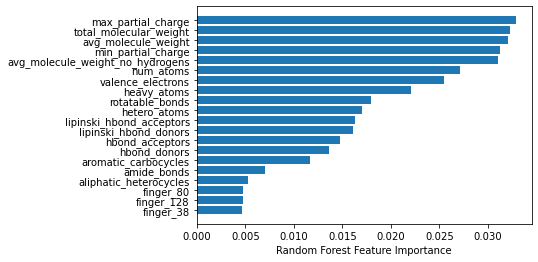

In [34]:
top_features = 20

feature_names = X.columns

forest_importances = pd.Series(importances, index=feature_names)

sorted_idx = model.feature_importances_.argsort()[-top_features:]

plt.barh(feature_names[sorted_idx], forest_importances[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Text(0.5, 0, 'Random Forest Feature Importance')

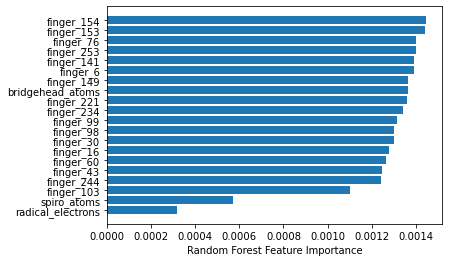

In [31]:
bottom_features = 20

feature_names = X.columns

forest_importances = pd.Series(importances, index=feature_names)

sorted_idx = model.feature_importances_.argsort()[0:bottom_features]

plt.barh(feature_names[sorted_idx], forest_importances[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

There are multiple ways to convert a molecule from SMILES format into features that can be used by a model.

Option 1: Create Graph. This forces us to use something that takes graphs as inputs (e.g. graph neural networks)

In [8]:
ELEMENTS = {
    0: "X",
    1: "H",
    6: "C",
    7: "N",
    8: "O",
    9: "F",
    14: "Si",
    15: "P",
    16: "S",
    17: "Cl",
    80: "Hg",
}

def convert_to_graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    
    N = len(list(m.GetAtoms()))
    
    nodes = np.zeros((N, len(ELEMENTS)))
    lookup = list(ELEMENTS.keys())
    for i in m.GetAtoms():
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

    adj = np.zeros((N, N, 5))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v, order] = 1
        adj[v, u, order] = 1
    return nodes, adj


Option 2: Convert to single array.

In [74]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit import Chem, DataStructs


def convert_to_bits(mol):
    
    fingerprint = rdMolDescriptors.GetMorganFingerprintAsBitVect(
        mol, radius=2, bitInfo={}, nBits=256, useChirality=True,
    )
    
    arr = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(fingerprint, arr)

    return list(arr)

In [25]:
df_test = df_t.iloc[0]
len(convert_to_bits(df_test['molecule']))

256

In [49]:
size = df_t.shape[0]

for i in range(size):
    mol = df_t['molecule'].iloc[i]
    try:
        convert_to_bits(mol)
    except:
        print(f"Failed at {i}")
    else:
        continue

In [67]:
cols = [f"finger_{i}" for i in range(256)]
df_t[cols] = df_t['molecule'].apply(
    lambda mol: convert_to_bits(mol)
)
df_t

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [76]:
cols = [f"finger_{i}" for i in range(256)]
df_t[cols] = df_t.apply(lambda row: convert_to_bits(row['molecule']), axis = 1, result_type = 'expand')
df_t

,molecule,toxicity_target,radical_electrons,total_molecular_weight,avg_molecule_weight_no_hydrogens,valence_electrons,avg_molecule_weight,max_partial_charge,min_partial_charge,aliphatic_carbocycles,...,finger_246,finger_247,finger_248,finger_249,finger_250,finger_251,finger_252,finger_253,finger_254,finger_255
0,<rdkit.Chem.rdchem.Mol object at 0x00000298040...,1,0,156.993056,153.524,52,157.556,0.269027,-0.258310,0,...,0,0,0,0,1,0,0,0,0,0
1,<rdkit.Chem.rdchem.Mol object at 0x000002986EA...,0,0,282.095901,256.429,92,282.637,0.311959,-0.439524,0,...,0,0,0,0,0,0,0,0,0,0
2,<rdkit.Chem.rdchem.Mol object at 0x000002986EA...,1,0,210.173213,188.145,86,210.321,0.225268,-0.339894,1,...,1,0,0,0,0,1,0,0,0,1
3,<rdkit.Chem.rdchem.Mol object at 0x000002986EA...,1,0,138.042927,132.078,52,138.126,0.269075,-0.398722,0,...,0,0,0,0,1,0,0,0,0,0
4,<rdkit.Chem.rdchem.Mol object at 0x000002986EA...,1,0,139.026943,134.070,52,139.110,0.269195,-0.507958,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8592,<rdkit.Chem.rdchem.Mol object at 0x000002986D9...,0,0,299.080299,283.186,110,299.314,0.485235,-0.741155,0,...,0,0,0,0,0,0,0,0,0,0
8593,<rdkit.Chem.rdchem.Mol object at 0x000002986D9...,1,0,295.092455,279.079,108,295.207,0.177693,-0.202731,0,...,0,0,0,0,0,0,0,0,0,0
8594,<rdkit.Chem.rdchem.Mol object at 0x000002986D9...,0,0,277.095949,259.164,104,277.308,0.485235,-0.741155,0,...,1,0,0,0,0,0,0,0,0,0
8595,<rdkit.Chem.rdchem.Mol object at 0x000002986D9...,1,0,724.595704,639.522,290,725.202,0.124200,-0.744028,0,...,0,1,0,0,0,0,0,0,0,0


Let's see what these features look like...

CN(C)c1nc(nc(n1)N(C)C)N(C)C


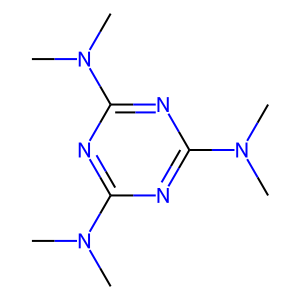

In [10]:
molecule = random_molecule()
display_molecule(molecule)

Note: if you get an error about a number not being in a list, that probably means that atomic number is missing from `ELEMENTS` above

In [11]:
convert_to_graph(molecule)

(array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.,

In [12]:
convert_to_bits(molecule)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])